# Facial Emotion Recognition Project

## Goal: Build a CNN to classify emotions on the basis of facial images


### Steps:
1. Build CNN based on resnet34, pretrained on imagenet
2. Train on 7 emotions from KDEF dataset
3. Test on test images
4. Train on Kaggle FER dataset
5. Repeat test on test images
6. Train on Google images dataset
7. Repeat test on test images

## Code: Initial Setup

Special directives to jupyter for reloading code and plotting graphs.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Include required fastai libraries

In [2]:
from fastai.vision import *
from fastai.metrics import accuracy, error_rate

We need to specify a batch_size for the GPU. Typically batch size of 64 works, but for resource constrained, smaller GPUs, reset bs to 16 if you run out of memory. If GPU runs out of memory, try again after restarting kernel.

In [3]:
bs = 64

Need to set the random seed upfront if using pct % to create a validation set. Fixed seed will ensure the same set of images always end up in the validation set. This is critical across runs.

In [4]:
np.random.seed(42)

### Setup folders/paths for datasets, label names etc

Setting up primary path to all datsets. 

Primary Path: /tutorials/fastai/course-v3/nbs/dl1/nbdata/ferbigdata

Emotion Labels (7): afraid, angry, disgusted, happy, neutral, sad, surprised

In [5]:
#create primary path object
path = Path('nbdata/ferbigdata')
#create labels list
emoclasses = ['afraid', 'angry', 'disgusted', 'happy', 'neutral', 'sad', 'surprised']
print(path)
print(emoclasses)

nbdata/ferbigdata
['afraid', 'angry', 'disgusted', 'happy', 'neutral', 'sad', 'surprised']


## Iteration 1 on KDEF Dataset: Get Data, Model, Train, Test

### Description: KDEF Dataset

One of many highly cited datasets for Emotion Recognition using Facial Expressions is the [KDEF dataset](http://kdef.se/home/aboutKDEF.html) which contains facial images classified under 7 different emotions. KDEF has 4900 pictures of human facial expressions: 70 individuals displaying 7 different emotional expressions. Each expression viewed from 5 different angles.

Note about dataset demographic: 70 amateur actors, 35 females and 35 males. Age between 20 and 30 years of age. No beards, mustaches, earrings or eyeglasses, and preferably no visible make-up during photo-session.

Referenced in ML: 
1. Deep FER Survey (https://arxiv.org/pdf/1804.08348.pdf)
2. Feature Maps for FER CNN (https://ieeexplore.ieee.org/abstract/document/7966100)
3. CNN for FER (https://ieeexplore.ieee.org/abstract/document/8770616)

Referenced in Psychology:
1. FER Validation Study (https://link.springer.com/content/pdf/10.3758/brm.40.1.109.pdf)
2. FER Algorithm vs Humans (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4565996/)
3. Dynamic KDEF (https://www.frontiersin.org/articles/10.3389/fpsyg.2018.02052/full)

### Preprocessing: KDEF Dataset

The kdef dataset has already been downloaded and images separated into 7 folders under path/kdef. Now specifying path and verifying the images. After this we can create a databunch using the API method to view the data and build learner.

In [6]:
#setup kdef training path
kdeftpath = path/'kdef'
print(kdeftpath)

nbdata/ferbigdata/kdef


In [7]:
#"download" and verify images (using fast.ai lesson 2 code)
for i in range(len(emoclasses)):
    dest = kdeftpath/emoclasses[i]
    print("Destination folder set to", dest)
    print("\nVerifying images now..")
    verify_images(dest, delete=True, max_workers=8)

Destination folder set to nbdata/ferbigdata/kdef/afraid

Verifying images now..
Destination folder set to nbdata/ferbigdata/kdef/angry

Verifying images now..
Destination folder set to nbdata/ferbigdata/kdef/disgusted

Verifying images now..
Destination folder set to nbdata/ferbigdata/kdef/happy

Verifying images now..
Destination folder set to nbdata/ferbigdata/kdef/neutral

Verifying images now..
Destination folder set to nbdata/ferbigdata/kdef/sad

Verifying images now..
Destination folder set to nbdata/ferbigdata/kdef/surprised

Verifying images now..


#### Creating the databunch using the Data Block API of fastai.

In [8]:
# setup transforms (keeping it to defaults for now)
tfms = get_transforms(do_flip=False)

In [18]:
help(get_transforms)

Help on function get_transforms in module fastai.vision.transform:

get_transforms(do_flip: bool = True, flip_vert: bool = False, max_rotate: float = 10.0, max_zoom: float = 1.1, max_lighting: float = 0.2, max_warp: float = 0.2, p_affine: float = 0.75, p_lighting: float = 0.75, xtra_tfms: Union[Collection[fastai.vision.image.Transform], NoneType] = None) -> Collection[fastai.vision.image.Transform]
    Utility func to easily create a list of flip, rotate, `zoom`, warp, lighting transforms.



In [9]:
kdefdata = (ImageList.from_folder(kdeftpath) #point to location of data
            .split_by_rand_pct()             #specify how to create training & validation sets
            .label_from_folder()             #extract labels (in this case from folder names)
            .transform(tfms, size=(224,224)) #applying default transforms for now
            .databunch(num_workers=4)        #convert list to databunch
            .normalize(imagenet_stats))      #normalizing to imagenet specifications 

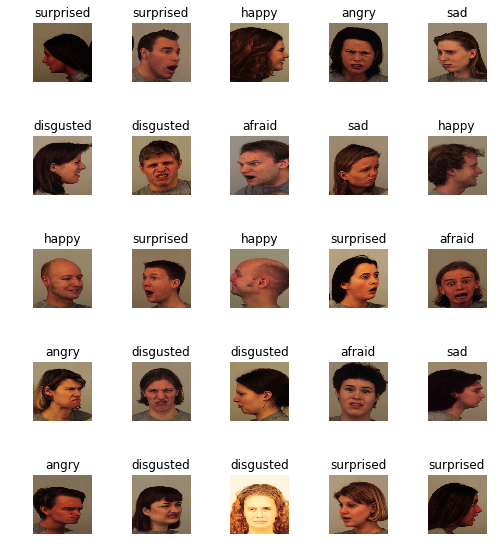

In [10]:
# verify all is well
kdefdata.classes, kdefdata.c, len(kdefdata.train_ds), len(kdefdata.valid_ds)
kdefdata.show_batch(rows=5, figsize=(7,8))

In [11]:
print(kdefdata)

ImageDataBunch;

Train: LabelList (3916 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
surprised,surprised,surprised,surprised,surprised
Path: nbdata/ferbigdata/kdef;

Valid: LabelList (978 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
surprised,surprised,angry,neutral,angry
Path: nbdata/ferbigdata/kdef;

Test: None


### NN Training: KDEF Dataset

In [12]:
learnkdef = cnn_learner(kdefdata, models.resnet34, metrics=[error_rate,accuracy])

#### Stage 1: Training 10 epochs with normalized databunch

In [13]:
learnkdef.fit_one_cycle(10)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,2.220124,1.707987,0.673824,0.326176,00:49
1,1.890041,1.499261,0.591002,0.408998,00:38
2,1.626742,1.256938,0.503067,0.496933,00:39
3,1.402554,1.104211,0.436605,0.563395,00:38
4,1.232589,0.980078,0.397750,0.602250,00:39
5,1.101530,0.918258,0.346626,0.653374,00:38
6,1.004897,0.857542,0.336401,0.663599,00:38
7,0.926485,0.822697,0.312883,0.687117,00:39
8,0.871212,0.816881,0.309816,0.690184,00:39
9,0.855292,0.813293,0.313906,0.686094,00:38


In [14]:
learnkdef.save('nbfer-kdef-stage1acc70')

#### Stage 1 done. Accuracy = 68%. Now unfreeze and train some more.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


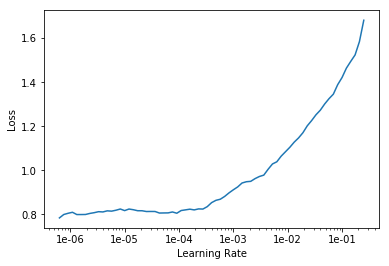

In [15]:
learnkdef.unfreeze()
learnkdef.lr_find()
learnkdef.recorder.plot()

In [16]:
#training stage 2 with lr slice
learnkdef.fit_one_cycle(10, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.845756,0.788330,0.296524,0.703476,00:39
1,0.810318,0.736689,0.292434,0.707566,00:39
2,0.751302,0.656605,0.247444,0.752556,00:39
3,0.684843,0.594060,0.214724,0.785276,00:39
4,0.604272,0.552505,0.200409,0.799591,00:39
5,0.548119,0.524147,0.195297,0.804703,00:40
6,0.498865,0.499149,0.187117,0.812883,00:40
7,0.475945,0.491183,0.176892,0.823108,00:39
8,0.459076,0.483201,0.172802,0.827198,00:40
9,0.445907,0.487183,0.177914,0.822086,00:39


In [17]:
learnkdef.save('nbfer-kdef-stage2acc82')

#### Stage 2 done. Accuracy = 82%. Now unfreeze and train some more.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


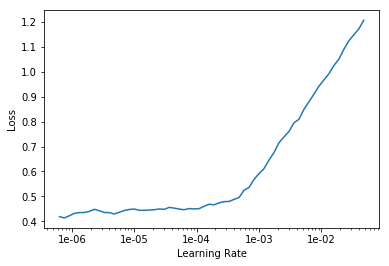

In [18]:
learnkdef.unfreeze()
learnkdef.lr_find()
learnkdef.recorder.plot()

In [19]:
learnkdef.fit_one_cycle(10, max_lr=slice(1e-6,1e-5))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.436441,0.484635,0.179959,0.820041,00:39
1,0.444738,0.477883,0.171779,0.828221,00:39
2,0.424958,0.469958,0.174847,0.825153,00:39
3,0.415353,0.452827,0.169734,0.830266,00:39
4,0.404597,0.460085,0.174847,0.825153,00:39
5,0.390256,0.446266,0.165644,0.834356,00:39
6,0.380131,0.437255,0.153374,0.846626,00:39
7,0.379512,0.433585,0.156442,0.843558,00:39
8,0.371388,0.429424,0.154397,0.845603,00:39
9,0.366614,0.430819,0.155419,0.844581,00:39


In [20]:
learnkdef.save('nbfer-kdef-stage3acc84')

#### Stage 3 done. Accuracy = 84%. Now unfreeze and train some more.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


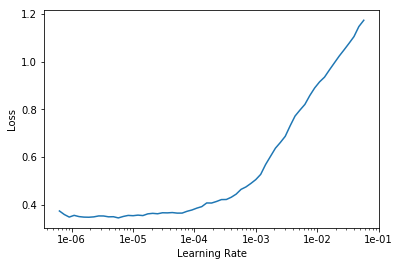

In [21]:
learnkdef.unfreeze()
learnkdef.lr_find()
learnkdef.recorder.plot()

In [22]:
learnkdef.fit_one_cycle(10, max_lr=slice(1e-7,1e-4))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.372273,0.425110,0.152352,0.847648,00:39
1,0.371262,0.422197,0.151329,0.848671,00:39
2,0.371870,0.411193,0.149284,0.850716,00:39
3,0.357337,0.403611,0.148262,0.851738,00:39
4,0.340858,0.400796,0.147239,0.852761,00:39
5,0.318303,0.396922,0.149284,0.850716,00:40
6,0.310430,0.388035,0.145194,0.854806,00:39
7,0.304770,0.383905,0.141104,0.858896,00:40
8,0.298608,0.381226,0.145194,0.854806,00:39
9,0.294807,0.389540,0.143149,0.856851,00:40


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


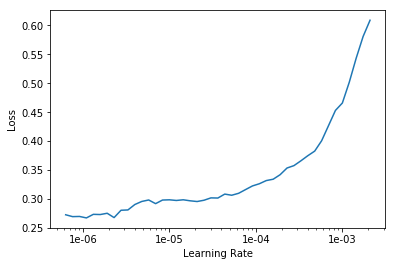

In [23]:
learnkdef.unfreeze()
learnkdef.lr_find()
learnkdef.recorder.plot()

In [24]:
learnkdef.fit_one_cycle(10, max_lr=slice(1e-7,3e-6))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.282292,0.389179,0.144172,0.855828,00:39
1,0.280097,0.379355,0.143149,0.856851,00:38
2,0.283273,0.380191,0.140082,0.859918,00:39
3,0.306148,0.380940,0.139059,0.860941,00:39
4,0.298514,0.382943,0.142127,0.857873,00:39
5,0.298465,0.379772,0.142127,0.857873,00:40
6,0.285944,0.383591,0.138037,0.861963,00:39
7,0.288794,0.379830,0.143149,0.856851,00:39
8,0.287178,0.378030,0.142127,0.857873,00:40
9,0.297463,0.380508,0.141104,0.858896,00:39


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


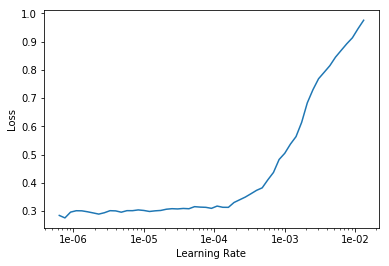

In [25]:
learnkdef.unfreeze()
learnkdef.lr_find()
learnkdef.recorder.plot()

##### Accuracy improving super slowly, almost not.. going back to higher/default LR to bump out and see if accuracy improves as a result of that.

In [26]:
learnkdef.fit_one_cycle(10)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.389600,0.538935,0.189162,0.810838,00:39
1,0.536900,0.741414,0.263804,0.736196,00:39
2,0.532970,0.606174,0.208589,0.791411,00:40
3,0.401703,0.668660,0.217791,0.782209,00:39
4,0.319018,0.431755,0.133947,0.866053,00:40
5,0.243335,0.398740,0.143149,0.856851,00:40
6,0.171691,0.223434,0.080777,0.919223,00:39
7,0.116246,0.158830,0.052147,0.947853,00:40
8,0.075951,0.149420,0.056237,0.943763,00:39
9,0.053195,0.146887,0.050102,0.949898,00:39


Question: Wow, accuracy improved by a lot by going back to higher LR. Does this mean I was stuck in a local minima? Or did I just not train for long enough earlier?

In [27]:
learnkdef.save('nbfer-kdef-stage4acc95')

#### Stage 4 done. Accuracy = 95%. Good enough for now. Moving on to interpretation.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


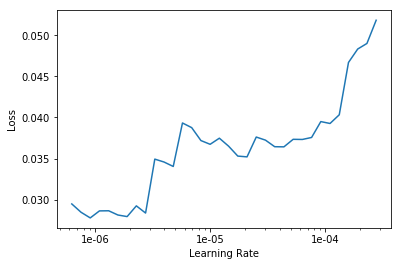

In [28]:
learnkdef.unfreeze()
learnkdef.lr_find()
learnkdef.recorder.plot()

### Interpretation

[('afraid', 'surprised', 9),
 ('surprised', 'afraid', 7),
 ('angry', 'disgusted', 6),
 ('afraid', 'sad', 5),
 ('sad', 'neutral', 5),
 ('sad', 'afraid', 3),
 ('afraid', 'angry', 2),
 ('angry', 'neutral', 2),
 ('sad', 'angry', 2),
 ('sad', 'disgusted', 2)]

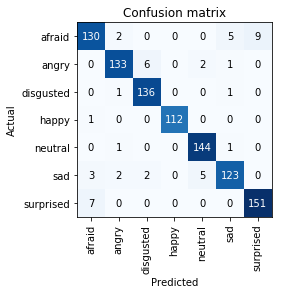

In [29]:
learnkdef.load('nbfer-kdef-stage4acc95')
interp = ClassificationInterpretation.from_learner(learnkdef)
interp.plot_confusion_matrix()
interp.most_confused(min_val=2)

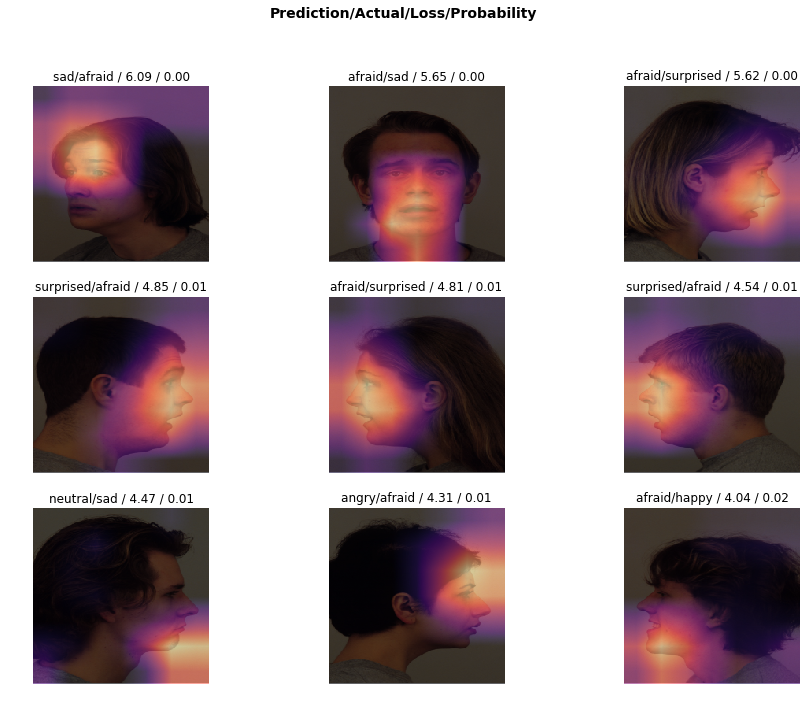

In [30]:
interp.plot_top_losses(9, figsize=(15,11), heatmap=True)

### Analysis and Bias Testing

Possible next steps: Test predictions against handpicked test set. Also check heatmap on them.